# SDAB Melting Temperature Prediction using DL

### Load Modules and Datasets

In [34]:
### Initialize seed for reproducibility
import numpy as np
np.random.seed(0)
import math

### Data Wrangling and Plots
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
import keras

In [35]:
def split_biased(data, y, split_column='source', holdout_var = "Camel"):
    """
    Create a split that holds out one group and splits the other one.
    """
    # data set for training
    x_train_all = data[meta[split_column] != holdout_var]
    y_train_all = y[meta[split_column] != holdout_var]

    #data set for validation
    x_val = data[meta[split_column] == holdout_var]
    y_val = y[meta[split_column] == holdout_var]

    #train, test split
    x_train, x_test, y_train, y_test = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=42)

    return x_train, y_train, x_test, y_test, x_val, y_val

### DL Model: Keras Sequential API for ANN

In [36]:
def create_model():
    model = Sequential([
        keras.layers.Dense(128, 
                           input_shape = (x.shape[1],), # input shape is the number of predictors
                           activation = 'relu'), # Input Layer
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(256, 
                           activation = 'relu'), # Hidden Layer (mean of neurons in the input and output layers.)
        keras.layers.Dense(1, 
                           activation = 'linear') # If the NN is a regressor, then the output layer has a single node.
    ])
    
    model.compile(
        loss = 'mae',
        optimizer = 'adam',
        metrics= ['mae']
    )
    
    model.summary()

    return model

In [37]:
def compute_accuracies(model, x_test, y_test):
    """
    Compute the accuracies
    """

    mae = mean_absolute_error(y_test, model.predict(x_test))
    rmse = math.sqrt(mean_squared_error(y_test, model.predict(x_test)))
    coeff_det=r2_score(y_test, model.predict(x_test))
    return mae, rmse, coeff_det
    

#### Read training data from datafolder

In [38]:
data = pd.read_csv("../data/sdab_protein_embeddings_t6.csv", header = None)
data.head()
meta = pd.read_csv('../data/augmented_metadata.tsv')
y = pd.read_excel("../data/sdab_data.xlsx")

y = y.tm
x = data

In [39]:
meta.loc[meta.source.isin(['Arabian camel (Camelus dromedarius)', 'Dromedary']), 'source'] = "Dromedary"

# Biased trainings
## Split by species

In [40]:
species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Dromedary']
list_of_error = []
for i in range(10):
    for animal in species:
        print(animal)
        x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
        callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
        model = create_model()
        model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
        mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
        list_of_error.append([animal, mae, rmse, coeff_det])

Llama


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 67.7104 - mae: 67.7104 - val_loss: 59.7965 - val_mae: 59.7965
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.4089 - mae: 58.4089 - val_loss: 30.7394 - val_mae: 30.7394
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.6706 - mae: 22.6706 - val_loss: 20.1948 - val_mae: 20.1948
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.6378 - mae: 14.6378 - val_loss: 10.6500 - val_mae: 10.6500
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4067 - mae: 11.4067 - val_loss: 12.0594 - val_mae: 12.0594
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6341 - mae: 9.6341 - val_loss: 7.8997 - val_mae: 7.8997
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4989 - mae: 9.4989 - val_loss: 8.4226 - val_mae: 8.4226
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7281 - mae: 8.7281 - val_loss: 7.7056 - val_mae: 7.7056
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 64.6066 - mae: 64.6066 - val_loss: 37.3384 - val_mae: 37.3384
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.1371 - mae: 22.1371 - val_loss: 15.7725 - val_mae: 15.7725
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0948 - mae: 12.0948 - val_loss: 9.1005 - val_mae: 9.1005
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3982 - mae: 8.3982 - val_loss: 8.8752 - val_mae: 8.8752
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4311 - mae: 8.4311 - val_loss: 8.6399 - val_mae: 8.6399
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1257 - mae: 8.1257 - val_loss: 8.8692 - val_mae: 8.8692
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1344 - mae: 8.1344 - val_loss: 8.5354 - val_mae: 8.5354
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3146 - mae: 8.3146 - val_loss: 7.8993 - val_mae: 7.8993
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 64.3468 - mae: 64.3468 - val_loss: 53.5490 - val_mae: 53.5490
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.9376 - mae: 39.9376 - val_loss: 21.0969 - val_mae: 21.0969
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.1924 - mae: 15.1924 - val_loss: 10.1154 - val_mae: 10.1154
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7303 - mae: 8.7303 - val_loss: 8.0788 - val_mae: 8.0788
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5311 - mae: 8.5311 - val_loss: 7.9979 - val_mae: 7.9979
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3006 - mae: 8.3006 - val_loss: 7.9080 - val_mae: 7.9080
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2286 - mae: 8.2286 - val_loss: 7.6769 - val_mae: 7.6769
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5666 - mae: 7.5666 - val_loss: 7.5381 - val_mae: 7.5381
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_95 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 65.2515 - mae: 65.2515 - val_loss: 42.9989 - val_mae: 42.9989
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28.2084 - mae: 28.2084 - val_loss: 9.6071 - val_mae: 9.6071
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7180 - mae: 10.7180 - val_loss: 8.7771 - val_mae: 8.7771
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6449 - mae: 8.6449 - val_loss: 9.3515 - val_mae: 9.3515
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6754 - mae: 8.6754 - val_loss: 10.1464 - val_mae: 10.1464
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3167 - mae: 8.3167 - val_loss: 9.9146 - val_mae: 9.9146
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1527 - mae: 8.1527 - val_loss: 11.3325 - val_mae: 11.3325
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9054 - mae: 8.9054 - val_loss: 9.3891 - val_mae: 9.3891
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 63.0540 - mae: 63.0540 - val_loss: 24.5693 - val_mae: 24.5693
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.5137 - mae: 17.5137 - val_loss: 10.2515 - val_mae: 10.2515
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4743 - mae: 9.4743 - val_loss: 9.3323 - val_mae: 9.3323
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2876 - mae: 8.2876 - val_loss: 9.0884 - val_mae: 9.0884
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9409 - mae: 7.9409 - val_loss: 8.9384 - val_mae: 8.9384
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7785 - mae: 7.7785 - val_loss: 9.0641 - val_mae: 9.0641
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5158 - mae: 7.5158 - val_loss: 8.6161 - val_mae: 8.6161
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3111 - mae: 8.3111 - val_loss: 8.4870 - val_mae: 8.4870
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - los

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.5576 - mae: 63.5576 - val_loss: 35.0269 - val_mae: 35.0269
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.8169 - mae: 20.8169 - val_loss: 13.8449 - val_mae: 13.8449
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.8504 - mae: 10.8504 - val_loss: 10.1649 - val_mae: 10.1649
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5143 - mae: 9.5143 - val_loss: 8.7655 - val_mae: 8.7655
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3104 - mae: 8.3104 - val_loss: 8.4772 - val_mae: 8.4772
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8360 - mae: 7.8360 - val_loss: 8.3295 - val_mae: 8.3295
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5120 - mae: 7.5120 - val_loss: 8.2816 - val_mae: 8.2816
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4230 - mae: 7.4230 - val_loss: 8.0862 - val_mae: 8.0862
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step -

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_110 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 67.8185 - mae: 67.8185 - val_loss: 59.2369 - val_mae: 59.2369
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 57.1689 - mae: 57.1689 - val_loss: 27.9031 - val_mae: 27.9031
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 20.3212 - mae: 20.3212 - val_loss: 20.0244 - val_mae: 20.0244
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13.7334 - mae: 13.7334 - val_loss: 11.6763 - val_mae: 11.6763
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.4046 - mae: 12.4046 - val_loss: 12.8471 - val_mae: 12.8471
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.9314 - mae: 10.9314 - val_loss: 8.0737 - val_mae: 8.0737
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7118 - mae: 8.7118 - val_loss: 9.5633 - val_mae: 9.5633
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3810 - mae: 9.3810 - val_loss: 7.7336 - val_mae: 7.7336
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_118 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_119 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 63.9467 - mae: 63.9467 - val_loss: 33.7302 - val_mae: 33.7302
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.4676 - mae: 20.4676 - val_loss: 15.3564 - val_mae: 15.3564
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8864 - mae: 10.8864 - val_loss: 10.2835 - val_mae: 10.2835
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.6425 - mae: 9.6425 - val_loss: 8.9497 - val_mae: 8.9497
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1266 - mae: 8.1266 - val_loss: 8.2677 - val_mae: 8.2677
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4460 - mae: 7.4460 - val_loss: 8.2916 - val_mae: 8.2916
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8079 - mae: 7.8079 - val_loss: 7.9401 - val_mae: 7.9401
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3685 - mae: 7.3685 - val_loss: 8.6276 - val_mae: 8.6276
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_120 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 63.6095 - mae: 63.6095 - val_loss: 48.4968 - val_mae: 48.4968
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.1604 - mae: 34.1604 - val_loss: 14.3659 - val_mae: 14.3659
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.6147 - mae: 11.6147 - val_loss: 8.3301 - val_mae: 8.3301
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2828 - mae: 9.2828 - val_loss: 9.8270 - val_mae: 9.8270
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0744 - mae: 9.0744 - val_loss: 7.9578 - val_mae: 7.9578
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8509 - mae: 8.8509 - val_loss: 8.4741 - val_mae: 8.4741
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2450 - mae: 9.2450 - val_loss: 7.7244 - val_mae: 7.7244
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1933 - mae: 8.1933 - val_loss: 7.7255 - val_mae: 7.7255
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_125 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_127 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.0784 - mae: 65.0784 - val_loss: 31.2601 - val_mae: 31.2601
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.9937 - mae: 19.9937 - val_loss: 13.1257 - val_mae: 13.1257
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5984 - mae: 11.5984 - val_loss: 8.9490 - val_mae: 8.9490
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4447 - mae: 8.4447 - val_loss: 8.9028 - val_mae: 8.9028
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8252 - mae: 7.8252 - val_loss: 9.5626 - val_mae: 9.5626
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2875 - mae: 8.2875 - val_loss: 8.6801 - val_mae: 8.6801
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4987 - mae: 7.4987 - val_loss: 8.4533 - val_mae: 8.4533
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1305 - mae: 8.1305 - val_loss: 8.5508 - val_mae: 8.5508
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_130 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_134 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.1340 - mae: 63.1340 - val_loss: 17.8699 - val_mae: 17.8699
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.3209 - mae: 15.3209 - val_loss: 9.3571 - val_mae: 9.3571
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8817 - mae: 8.8817 - val_loss: 9.2485 - val_mae: 9.2485
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0202 - mae: 8.0202 - val_loss: 9.0109 - val_mae: 9.0109
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7708 - mae: 7.7708 - val_loss: 8.8879 - val_mae: 8.8879
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6616 - mae: 7.6616 - val_loss: 8.7003 - val_mae: 8.7003
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9635 - mae: 7.9635 - val_loss: 8.5245 - val_mae: 8.5245
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2190 - mae: 7.2190 - val_loss: 8.6085 - val_mae: 8.6085
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 62.9323 - mae: 62.9323 - val_loss: 27.7924 - val_mae: 27.7924
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.6836 - mae: 18.6836 - val_loss: 14.3949 - val_mae: 14.3949
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.6634 - mae: 11.6634 - val_loss: 8.8200 - val_mae: 8.8200
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5716 - mae: 8.5716 - val_loss: 8.7336 - val_mae: 8.7336
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2478 - mae: 8.2478 - val_loss: 8.5427 - val_mae: 8.5427
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5158 - mae: 8.5158 - val_loss: 8.3371 - val_mae: 8.3371
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4812 - mae: 7.4812 - val_loss: 8.2348 - val_mae: 8.2348
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8129 - mae: 7.8129 - val_loss: 8.3256 - val_mae: 8.3256
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_140 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 67.8474 - mae: 67.8474 - val_loss: 60.8526 - val_mae: 60.8526
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59.7839 - mae: 59.7839 - val_loss: 36.7702 - val_mae: 36.7702
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.8133 - mae: 27.8133 - val_loss: 24.4774 - val_mae: 24.4774
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.7282 - mae: 16.7282 - val_loss: 11.9917 - val_mae: 11.9917
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.9708 - mae: 12.9708 - val_loss: 9.3746 - val_mae: 9.3746
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0992 - mae: 9.0992 - val_loss: 7.8425 - val_mae: 7.8425
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.0269 - mae: 9.0269 - val_loss: 7.8220 - val_mae: 7.8220
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2996 - mae: 8.2996 - val_loss: 8.2595 - val_mae: 8.2595
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.39

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.7775 - mae: 63.7775 - val_loss: 35.7388 - val_mae: 35.7388
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.3093 - mae: 20.3093 - val_loss: 15.6646 - val_mae: 15.6646
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.2539 - mae: 12.2539 - val_loss: 9.1058 - val_mae: 9.1058
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8371 - mae: 8.8371 - val_loss: 8.4156 - val_mae: 8.4156
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6131 - mae: 7.6131 - val_loss: 8.4378 - val_mae: 8.4378
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5626 - mae: 7.5626 - val_loss: 8.0758 - val_mae: 8.0758
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5377 - mae: 7.5377 - val_loss: 7.8967 - val_mae: 7.8967
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5886 - mae: 7.5886 - val_loss: 7.7183 - val_mae: 7.7183
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_150 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_153 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_154 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 64.8760 - mae: 64.8760 - val_loss: 51.9032 - val_mae: 51.9032
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 37.8730 - mae: 37.8730 - val_loss: 20.8895 - val_mae: 20.8895
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.7806 - mae: 14.7806 - val_loss: 11.5700 - val_mae: 11.5700
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7699 - mae: 9.7699 - val_loss: 8.0785 - val_mae: 8.0785
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0423 - mae: 8.0423 - val_loss: 8.0945 - val_mae: 8.0945
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8572 - mae: 8.8572 - val_loss: 8.0835 - val_mae: 8.0835
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4729 - mae: 7.4729 - val_loss: 7.8902 - val_mae: 7.8902
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1417 - mae: 8.1417 - val_loss: 7.7265 - val_mae: 7.7265
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_155 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.6818 - mae: 64.6818 - val_loss: 31.9828 - val_mae: 31.9828
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.9086 - mae: 19.9086 - val_loss: 13.2074 - val_mae: 13.2074
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.2504 - mae: 11.2504 - val_loss: 8.9116 - val_mae: 8.9116
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1322 - mae: 10.1322 - val_loss: 8.7479 - val_mae: 8.7479
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9997 - mae: 8.9997 - val_loss: 8.9543 - val_mae: 8.9543
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1184 - mae: 8.1184 - val_loss: 8.8119 - val_mae: 8.8119
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2093 - mae: 8.2093 - val_loss: 8.6450 - val_mae: 8.6450
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9311 - mae: 7.9311 - val_loss: 8.3230 - val_mae: 8.3230
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_160 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_163 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_164 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.3623 - mae: 63.3623 - val_loss: 16.7745 - val_mae: 16.7745
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.6488 - mae: 15.6488 - val_loss: 10.3135 - val_mae: 10.3135
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.4035 - mae: 10.4035 - val_loss: 9.5405 - val_mae: 9.5405
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4417 - mae: 8.4417 - val_loss: 9.3918 - val_mae: 9.3918
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5671 - mae: 8.5671 - val_loss: 9.6958 - val_mae: 9.6958
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0154 - mae: 8.0154 - val_loss: 9.0454 - val_mae: 9.0454
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5588 - mae: 7.5588 - val_loss: 8.9304 - val_mae: 8.9304
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3957 - mae: 7.3957 - val_loss: 8.7503 - val_mae: 8.7503
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_165 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_166 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_167 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_168 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_169 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.7375 - mae: 63.7375 - val_loss: 24.0082 - val_mae: 24.0082
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.8113 - mae: 16.8113 - val_loss: 12.6226 - val_mae: 12.6226
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1907 - mae: 10.1907 - val_loss: 9.9984 - val_mae: 9.9984
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5170 - mae: 9.5170 - val_loss: 9.9518 - val_mae: 9.9518
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4681 - mae: 9.4681 - val_loss: 8.6989 - val_mae: 8.6989
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1342 - mae: 8.1342 - val_loss: 8.8934 - val_mae: 8.8934
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0715 - mae: 8.0715 - val_loss: 8.2338 - val_mae: 8.2338
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8941 - mae: 7.8941 - val_loss: 8.1786 - val_mae: 8.1786
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_170 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_171 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_174 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 67.2096 - mae: 67.2096 - val_loss: 60.7244 - val_mae: 60.7244
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 59.8135 - mae: 59.8135 - val_loss: 36.6602 - val_mae: 36.6602
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.4119 - mae: 27.4119 - val_loss: 24.9484 - val_mae: 24.9484
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 17.1410 - mae: 17.1410 - val_loss: 12.1955 - val_mae: 12.1955
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.4175 - mae: 14.4175 - val_loss: 9.1439 - val_mae: 9.1439
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4982 - mae: 9.4982 - val_loss: 7.8462 - val_mae: 7.8462
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2291 - mae: 8.2291 - val_loss: 7.6642 - val_mae: 7.6642
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.8421 - mae: 8.8421 - val_loss: 7.8347 - val_mae: 7.8347
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.45

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_175 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_176 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_177 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_178 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_179 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.7478 - mae: 64.7478 - val_loss: 43.2362 - val_mae: 43.2362
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.8845 - mae: 24.8845 - val_loss: 12.7267 - val_mae: 12.7267
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8805 - mae: 10.8805 - val_loss: 8.6268 - val_mae: 8.6268
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0992 - mae: 8.0992 - val_loss: 8.5218 - val_mae: 8.5218
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8217 - mae: 7.8217 - val_loss: 8.7213 - val_mae: 8.7213
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7541 - mae: 7.7541 - val_loss: 8.3856 - val_mae: 8.3856
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7723 - mae: 7.7723 - val_loss: 9.3949 - val_mae: 9.3949
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2374 - mae: 8.2374 - val_loss: 8.2811 - val_mae: 8.2811
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_180 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_181 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_182 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 64.4127 - mae: 64.4127 - val_loss: 53.6798 - val_mae: 53.6798
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 40.6736 - mae: 40.6736 - val_loss: 23.0422 - val_mae: 23.0422
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.4797 - mae: 17.4797 - val_loss: 11.0372 - val_mae: 11.0372
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4551 - mae: 9.4551 - val_loss: 8.1093 - val_mae: 8.1093
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2012 - mae: 9.2012 - val_loss: 8.2612 - val_mae: 8.2612
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8445 - mae: 8.8445 - val_loss: 7.9318 - val_mae: 7.9318
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1744 - mae: 8.1744 - val_loss: 7.8659 - val_mae: 7.8659
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3571 - mae: 8.3571 - val_loss: 7.8682 - val_mae: 7.8682
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_185 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_186 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.5232 - mae: 64.5232 - val_loss: 36.2203 - val_mae: 36.2203
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.2172 - mae: 23.2172 - val_loss: 11.9901 - val_mae: 11.9901
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.1922 - mae: 11.1922 - val_loss: 9.3273 - val_mae: 9.3273
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.1524 - mae: 10.1524 - val_loss: 9.1034 - val_mae: 9.1034
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3200 - mae: 8.3200 - val_loss: 9.8737 - val_mae: 9.8737
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0960 - mae: 8.0960 - val_loss: 8.4446 - val_mae: 8.4446
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7007 - mae: 7.7007 - val_loss: 8.2830 - val_mae: 8.2830
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8299 - mae: 7.8299 - val_loss: 8.4066 - val_mae: 8.4066
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_190 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 64.9145 - mae: 64.9145 - val_loss: 31.8231 - val_mae: 31.8231
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4756 - mae: 19.4756 - val_loss: 10.5630 - val_mae: 10.5630
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0480 - mae: 9.0480 - val_loss: 9.3110 - val_mae: 9.3110
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4231 - mae: 8.4231 - val_loss: 9.0487 - val_mae: 9.0487
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7230 - mae: 7.7230 - val_loss: 8.8867 - val_mae: 8.8867
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0010 - mae: 8.0010 - val_loss: 8.9198 - val_mae: 8.9198
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4509 - mae: 8.4509 - val_loss: 8.6050 - val_mae: 8.6050
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6151 - mae: 7.6151 - val_loss: 8.3701 - val_mae: 8.3701
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_195 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_198 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 64.1684 - mae: 64.1684 - val_loss: 38.5940 - val_mae: 38.5940
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.5821 - mae: 23.5821 - val_loss: 12.8969 - val_mae: 12.8969
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.1651 - mae: 12.1651 - val_loss: 8.7624 - val_mae: 8.7624
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2832 - mae: 9.2832 - val_loss: 8.6749 - val_mae: 8.6749
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7106 - mae: 8.7106 - val_loss: 8.4469 - val_mae: 8.4469
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3367 - mae: 8.3367 - val_loss: 8.3313 - val_mae: 8.3313
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7588 - mae: 7.7588 - val_loss: 8.1511 - val_mae: 8.1511
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6268 - mae: 7.6268 - val_loss: 8.0661 - val_mae: 8.0661
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 68.1178 - mae: 68.1178 - val_loss: 61.0299 - val_mae: 61.0299
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 60.2694 - mae: 60.2694 - val_loss: 38.3959 - val_mae: 38.3959
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.4145 - mae: 28.4145 - val_loss: 25.7474 - val_mae: 25.7474
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.9645 - mae: 16.9645 - val_loss: 12.1615 - val_mae: 12.1615
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.6616 - mae: 14.6616 - val_loss: 8.5646 - val_mae: 8.5646
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8087 - mae: 8.8087 - val_loss: 7.9362 - val_mae: 7.9362
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9267 - mae: 8.9267 - val_loss: 7.8495 - val_mae: 7.8495
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6309 - mae: 8.6309 - val_loss: 8.5902 - val_mae: 8.5902
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.50

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_205 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_208 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 64.4903 - mae: 64.4903 - val_loss: 35.5870 - val_mae: 35.5870
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.9923 - mae: 20.9923 - val_loss: 15.0657 - val_mae: 15.0657
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.2009 - mae: 11.2009 - val_loss: 9.3479 - val_mae: 9.3479
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6264 - mae: 8.6264 - val_loss: 8.8397 - val_mae: 8.8397
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0866 - mae: 8.0866 - val_loss: 8.3747 - val_mae: 8.3747
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2759 - mae: 7.2759 - val_loss: 8.1992 - val_mae: 8.1992
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6794 - mae: 7.6794 - val_loss: 8.2390 - val_mae: 8.2390
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8024 - mae: 7.8024 - val_loss: 7.9936 - val_mae: 7.9936
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_210 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_213 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 63.6757 - mae: 63.6757 - val_loss: 53.0907 - val_mae: 53.0907
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.4615 - mae: 40.4615 - val_loss: 17.4922 - val_mae: 17.4922
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.9098 - mae: 13.9098 - val_loss: 9.7242 - val_mae: 9.7242
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0087 - mae: 9.0087 - val_loss: 8.3382 - val_mae: 8.3382
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6047 - mae: 8.6047 - val_loss: 8.9605 - val_mae: 8.9605
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1617 - mae: 9.1617 - val_loss: 8.2751 - val_mae: 8.2751
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3664 - mae: 7.3664 - val_loss: 7.8771 - val_mae: 7.8771
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3869 - mae: 8.3869 - val_loss: 8.4238 - val_mae: 8.4238
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_215 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_218 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 64.7032 - mae: 64.7032 - val_loss: 32.2541 - val_mae: 32.2541
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 21.0732 - mae: 21.0732 - val_loss: 13.7998 - val_mae: 13.7998
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.9502 - mae: 12.9502 - val_loss: 8.8422 - val_mae: 8.8422
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7764 - mae: 8.7764 - val_loss: 10.6231 - val_mae: 10.6231
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2962 - mae: 8.2962 - val_loss: 9.8895 - val_mae: 9.8895
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2207 - mae: 8.2207 - val_loss: 9.3947 - val_mae: 9.3947
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0313 - mae: 8.0313 - val_loss: 8.4792 - val_mae: 8.4792
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6715 - mae: 7.6715 - val_loss: 8.4999 - val_mae: 8.4999
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_220 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_223 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 65.4164 - mae: 65.4164 - val_loss: 41.6501 - val_mae: 41.6501
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.7242 - mae: 25.7242 - val_loss: 12.2252 - val_mae: 12.2252
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8387 - mae: 10.8387 - val_loss: 9.3846 - val_mae: 9.3846
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4643 - mae: 8.4643 - val_loss: 9.1795 - val_mae: 9.1795
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8204 - mae: 7.8204 - val_loss: 9.0776 - val_mae: 9.0776
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3052 - mae: 8.3052 - val_loss: 8.9101 - val_mae: 8.9101
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1350 - mae: 8.1350 - val_loss: 8.8740 - val_mae: 8.8740
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8597 - mae: 7.8597 - val_loss: 8.5208 - val_mae: 8.5208
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_225 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.1659 - mae: 64.1659 - val_loss: 33.4134 - val_mae: 33.4134
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4252 - mae: 19.4252 - val_loss: 11.7242 - val_mae: 11.7242
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2568 - mae: 10.2568 - val_loss: 9.4387 - val_mae: 9.4387
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8011 - mae: 8.8011 - val_loss: 8.8342 - val_mae: 8.8342
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9858 - mae: 7.9858 - val_loss: 8.4939 - val_mae: 8.4939
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3888 - mae: 8.3888 - val_loss: 8.3525 - val_mae: 8.3525
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3213 - mae: 8.3213 - val_loss: 8.3141 - val_mae: 8.3141
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1723 - mae: 8.1723 - val_loss: 8.1461 - val_mae: 8.1461
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_230 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_233 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 66.8090 - mae: 66.8090 - val_loss: 58.0817 - val_mae: 58.0817
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 55.4906 - mae: 55.4906 - val_loss: 22.5191 - val_mae: 22.5191
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.8596 - mae: 17.8596 - val_loss: 16.3580 - val_mae: 16.3580
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.0185 - mae: 12.0185 - val_loss: 11.5684 - val_mae: 11.5684
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.3344 - mae: 12.3344 - val_loss: 12.2334 - val_mae: 12.2334
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9875 - mae: 9.9875 - val_loss: 8.1620 - val_mae: 8.1620
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2246 - mae: 9.2246 - val_loss: 10.2286 - val_mae: 10.2286
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5700 - mae: 8.5700 - val_loss: 7.6573 - val_mae: 7.6573
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_235 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_238 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.5007 - mae: 65.5007 - val_loss: 45.4213 - val_mae: 45.4213
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.5370 - mae: 27.5370 - val_loss: 12.1827 - val_mae: 12.1827
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.7662 - mae: 11.7662 - val_loss: 8.7233 - val_mae: 8.7233
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2047 - mae: 8.2047 - val_loss: 8.6664 - val_mae: 8.6664
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2656 - mae: 8.2656 - val_loss: 8.3737 - val_mae: 8.3737
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2085 - mae: 7.2085 - val_loss: 8.3272 - val_mae: 8.3272
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5991 - mae: 7.5991 - val_loss: 8.0198 - val_mae: 8.0198
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3724 - mae: 7.3724 - val_loss: 7.8351 - val_mae: 7.8351
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_240 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 64.8222 - mae: 64.8222 - val_loss: 53.8077 - val_mae: 53.8077
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 41.3059 - mae: 41.3059 - val_loss: 17.4191 - val_mae: 17.4191
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8351 - mae: 13.8351 - val_loss: 9.2121 - val_mae: 9.2121
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1594 - mae: 9.1594 - val_loss: 8.4937 - val_mae: 8.4937
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3711 - mae: 8.3711 - val_loss: 8.0807 - val_mae: 8.0807
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9660 - mae: 7.9660 - val_loss: 7.9301 - val_mae: 7.9301
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9132 - mae: 7.9132 - val_loss: 7.7061 - val_mae: 7.7061
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4756 - mae: 8.4756 - val_loss: 7.9374 - val_mae: 7.9374
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_248 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.2931 - mae: 63.2931 - val_loss: 20.2828 - val_mae: 20.2828
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.9024 - mae: 16.9024 - val_loss: 11.8467 - val_mae: 11.8467
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1484 - mae: 10.1484 - val_loss: 9.1129 - val_mae: 9.1129
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6265 - mae: 8.6265 - val_loss: 8.7766 - val_mae: 8.7766
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2488 - mae: 8.2488 - val_loss: 8.5380 - val_mae: 8.5380
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8428 - mae: 7.8428 - val_loss: 8.3659 - val_mae: 8.3659
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4297 - mae: 8.4297 - val_loss: 8.5321 - val_mae: 8.5321
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1789 - mae: 8.1789 - val_loss: 8.8842 - val_mae: 8.8842
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_250 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 63.6353 - mae: 63.6353 - val_loss: 25.3294 - val_mae: 25.3294
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.9426 - mae: 16.9426 - val_loss: 11.0006 - val_mae: 11.0006
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.0751 - mae: 10.0751 - val_loss: 9.3305 - val_mae: 9.3305
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3571 - mae: 8.3571 - val_loss: 9.2618 - val_mae: 9.2618
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8916 - mae: 7.8916 - val_loss: 9.4370 - val_mae: 9.4370
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0994 - mae: 8.0994 - val_loss: 8.8791 - val_mae: 8.8791
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2908 - mae: 8.2908 - val_loss: 8.7474 - val_mae: 8.7474
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8039 - mae: 7.8039 - val_loss: 8.7900 - val_mae: 8.7900
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - l

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_255 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_258 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 63.8828 - mae: 63.8828 - val_loss: 32.5435 - val_mae: 32.5435
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.4962 - mae: 19.4962 - val_loss: 13.3837 - val_mae: 13.3837
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7501 - mae: 10.7501 - val_loss: 8.7959 - val_mae: 8.7959
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4649 - mae: 8.4649 - val_loss: 8.5686 - val_mae: 8.5686
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0530 - mae: 8.0530 - val_loss: 8.3981 - val_mae: 8.3981
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2728 - mae: 8.2728 - val_loss: 8.2819 - val_mae: 8.2819
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1353 - mae: 8.1353 - val_loss: 8.2156 - val_mae: 8.2156
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8379 - mae: 7.8379 - val_loss: 8.0539 - val_mae: 8.0539
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_260 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_263 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 66.9113 - mae: 66.9113 - val_loss: 59.0930 - val_mae: 59.0930
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 56.9883 - mae: 56.9883 - val_loss: 28.5376 - val_mae: 28.5376
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.1332 - mae: 22.1332 - val_loss: 20.8978 - val_mae: 20.8978
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14.9268 - mae: 14.9268 - val_loss: 11.2957 - val_mae: 11.2957
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.4684 - mae: 12.4684 - val_loss: 10.8768 - val_mae: 10.8768
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6599 - mae: 9.6599 - val_loss: 7.8785 - val_mae: 7.8785
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4401 - mae: 9.4401 - val_loss: 8.5185 - val_mae: 8.5185
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6949 - mae: 8.6949 - val_loss: 7.7835 - val_mae: 7.7835
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_265 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_268 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 64.9651 - mae: 64.9651 - val_loss: 44.7008 - val_mae: 44.7008
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.7921 - mae: 25.7921 - val_loss: 11.8073 - val_mae: 11.8073
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2013 - mae: 9.2013 - val_loss: 8.8200 - val_mae: 8.8200
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2656 - mae: 8.2656 - val_loss: 8.5123 - val_mae: 8.5123
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5974 - mae: 7.5974 - val_loss: 8.2806 - val_mae: 8.2806
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9183 - mae: 7.9183 - val_loss: 8.0949 - val_mae: 8.0949
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4645 - mae: 7.4645 - val_loss: 7.9180 - val_mae: 7.9180
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4464 - mae: 7.4464 - val_loss: 8.5130 - val_mae: 8.5130
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_270 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_273 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 64.5141 - mae: 64.5141 - val_loss: 55.9861 - val_mae: 55.9861
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44.6058 - mae: 44.6058 - val_loss: 19.3005 - val_mae: 19.3005
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 15.4479 - mae: 15.4479 - val_loss: 13.8314 - val_mae: 13.8314
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.5895 - mae: 10.5895 - val_loss: 8.2204 - val_mae: 8.2204
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2550 - mae: 8.2550 - val_loss: 8.0828 - val_mae: 8.0828
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.2521 - mae: 8.2521 - val_loss: 8.0192 - val_mae: 8.0192
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.0806 - mae: 8.0806 - val_loss: 7.8716 - val_mae: 7.8716
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1396 - mae: 8.1396 - val_loss: 7.8221 - val_mae: 7.8221
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/ste

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_275 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_278 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_279 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 64.5937 - mae: 64.5937 - val_loss: 34.7723 - val_mae: 34.7723
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.3057 - mae: 21.3057 - val_loss: 13.6844 - val_mae: 13.6844
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.5039 - mae: 12.5039 - val_loss: 9.1415 - val_mae: 9.1415
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3627 - mae: 8.3627 - val_loss: 10.6764 - val_mae: 10.6764
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7260 - mae: 8.7260 - val_loss: 9.4504 - val_mae: 9.4504
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3142 - mae: 8.3142 - val_loss: 8.4844 - val_mae: 8.4844
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8437 - mae: 7.8437 - val_loss: 8.5008 - val_mae: 8.5008
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4609 - mae: 7.4609 - val_loss: 8.3930 - val_mae: 8.3930
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_280 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_283 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_284 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 66.0082 - mae: 66.0082 - val_loss: 42.5033 - val_mae: 42.5033
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.3752 - mae: 27.3752 - val_loss: 12.6272 - val_mae: 12.6272
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.7259 - mae: 10.7259 - val_loss: 9.4293 - val_mae: 9.4293
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9057 - mae: 8.9057 - val_loss: 9.2870 - val_mae: 9.2870
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6727 - mae: 8.6727 - val_loss: 9.1285 - val_mae: 9.1285
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0039 - mae: 8.0039 - val_loss: 9.0670 - val_mae: 9.0670
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5648 - mae: 7.5648 - val_loss: 8.8225 - val_mae: 8.8225
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5257 - mae: 7.5257 - val_loss: 9.1375 - val_mae: 9.1375
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_285 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_286 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_287 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 65.6385 - mae: 65.6385 - val_loss: 48.2486 - val_mae: 48.2486
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30.9230 - mae: 30.9230 - val_loss: 10.4327 - val_mae: 10.4327
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4151 - mae: 11.4151 - val_loss: 8.8011 - val_mae: 8.8011
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9981 - mae: 7.9981 - val_loss: 8.6673 - val_mae: 8.6673
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0974 - mae: 8.0974 - val_loss: 8.5633 - val_mae: 8.5633
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0910 - mae: 8.0910 - val_loss: 8.4148 - val_mae: 8.4148
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7472 - mae: 7.7472 - val_loss: 8.2324 - val_mae: 8.2324
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7162 - mae: 7.7162 - val_loss: 8.3680 - val_mae: 8.3680
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_290 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_292 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_293 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_294 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 67.3863 - mae: 67.3863 - val_loss: 60.9038 - val_mae: 60.9038
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 60.6907 - mae: 60.6907 - val_loss: 37.5256 - val_mae: 37.5256
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.7427 - mae: 27.7427 - val_loss: 24.5830 - val_mae: 24.5830
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16.8451 - mae: 16.8451 - val_loss: 11.0352 - val_mae: 11.0352
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.1158 - mae: 12.1158 - val_loss: 9.2230 - val_mae: 9.2230
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9599 - mae: 9.9599 - val_loss: 7.8649 - val_mae: 7.8649
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9319 - mae: 8.9319 - val_loss: 7.9383 - val_mae: 7.9383
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6475 - mae: 8.6475 - val_loss: 7.7171 - val_mae: 7.7171
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.49

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_295 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_298 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.6895 - mae: 63.6895 - val_loss: 36.8567 - val_mae: 36.8567
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22.3196 - mae: 22.3196 - val_loss: 14.2270 - val_mae: 14.2270
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.2602 - mae: 11.2602 - val_loss: 9.6757 - val_mae: 9.6757
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1827 - mae: 9.1827 - val_loss: 8.5696 - val_mae: 8.5696
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7140 - mae: 7.7140 - val_loss: 8.3369 - val_mae: 8.3369
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2278 - mae: 7.2278 - val_loss: 8.2753 - val_mae: 8.2753
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6629 - mae: 7.6629 - val_loss: 7.9968 - val_mae: 7.9968
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4477 - mae: 7.4477 - val_loss: 7.7933 - val_mae: 7.7933
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_300 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_302 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_303 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_304 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 64.5189 - mae: 64.5189 - val_loss: 54.4994 - val_mae: 54.4994
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41.9588 - mae: 41.9588 - val_loss: 22.1816 - val_mae: 22.1816
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.5600 - mae: 17.5600 - val_loss: 13.6759 - val_mae: 13.6759
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.2564 - mae: 11.2564 - val_loss: 8.1246 - val_mae: 8.1246
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5510 - mae: 8.5510 - val_loss: 8.0178 - val_mae: 8.0178
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1176 - mae: 8.1176 - val_loss: 8.4622 - val_mae: 8.4622
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3350 - mae: 8.3350 - val_loss: 8.0064 - val_mae: 8.0064
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3248 - mae: 8.3248 - val_loss: 7.8744 - val_mae: 7.8744
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_305 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_306 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_307 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_308 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.6494 - mae: 64.6494 - val_loss: 37.1971 - val_mae: 37.1971
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.7526 - mae: 23.7526 - val_loss: 13.3033 - val_mae: 13.3033
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.8701 - mae: 12.8701 - val_loss: 9.0379 - val_mae: 9.0379
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4313 - mae: 9.4313 - val_loss: 9.5373 - val_mae: 9.5373
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9812 - mae: 7.9812 - val_loss: 8.8994 - val_mae: 8.8994
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2416 - mae: 8.2416 - val_loss: 8.7286 - val_mae: 8.7286
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.4711 - mae: 7.4711 - val_loss: 8.5983 - val_mae: 8.5983
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8757 - mae: 7.8757 - val_loss: 8.3453 - val_mae: 8.3453
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_310 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_313 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_314 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 64.3888 - mae: 64.3888 - val_loss: 39.9275 - val_mae: 39.9275
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.9837 - mae: 24.9837 - val_loss: 13.4749 - val_mae: 13.4749
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.6065 - mae: 12.6065 - val_loss: 9.9467 - val_mae: 9.9467
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.8226 - mae: 11.8226 - val_loss: 9.8012 - val_mae: 9.8012
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9276 - mae: 8.9276 - val_loss: 9.3250 - val_mae: 9.3250
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9783 - mae: 7.9783 - val_loss: 9.8653 - val_mae: 9.8653
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8588 - mae: 7.8588 - val_loss: 9.1164 - val_mae: 9.1164
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7781 - mae: 7.7781 - val_loss: 8.9195 - val_mae: 8.9195
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_315 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_316 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_317 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_318 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_319 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 65.1620 - mae: 65.1620 - val_loss: 35.1473 - val_mae: 35.1473
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.2674 - mae: 21.2674 - val_loss: 13.6019 - val_mae: 13.6019
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.4124 - mae: 11.4124 - val_loss: 9.0891 - val_mae: 9.0891
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2565 - mae: 8.2565 - val_loss: 8.6755 - val_mae: 8.6755
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4498 - mae: 8.4498 - val_loss: 8.4408 - val_mae: 8.4408
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8273 - mae: 7.8273 - val_loss: 8.3589 - val_mae: 8.3589
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8289 - mae: 7.8289 - val_loss: 8.2598 - val_mae: 8.2598
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4415 - mae: 7.4415 - val_loss: 8.0953 - val_mae: 8.0953
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_320 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_321 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_322 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_323 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 67.3347 - mae: 67.3347 - val_loss: 59.6858 - val_mae: 59.6858
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.4564 - mae: 58.4564 - val_loss: 29.8546 - val_mae: 29.8546
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 22.5315 - mae: 22.5315 - val_loss: 18.8642 - val_mae: 18.8642
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.8851 - mae: 12.8851 - val_loss: 11.1766 - val_mae: 11.1766
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.0744 - mae: 12.0744 - val_loss: 12.6003 - val_mae: 12.6003
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0530 - mae: 10.0530 - val_loss: 8.2753 - val_mae: 8.2753
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9935 - mae: 8.9935 - val_loss: 9.4668 - val_mae: 9.4668
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5697 - mae: 8.5697 - val_loss: 7.9199 - val_mae: 7.9199
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_325 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_326 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_327 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_328 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_329 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.9590 - mae: 63.9590 - val_loss: 32.2524 - val_mae: 32.2524
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1803 - mae: 18.1803 - val_loss: 13.4250 - val_mae: 13.4250
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1243 - mae: 10.1243 - val_loss: 9.8015 - val_mae: 9.8015
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0939 - mae: 9.0939 - val_loss: 9.2477 - val_mae: 9.2477
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1525 - mae: 8.1525 - val_loss: 8.6181 - val_mae: 8.6181
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6982 - mae: 7.6982 - val_loss: 8.6950 - val_mae: 8.6950
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9764 - mae: 7.9764 - val_loss: 10.2736 - val_mae: 10.2736
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8437 - mae: 8.8437 - val_loss: 8.6913 - val_mae: 8.6913
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_330 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_331 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_332 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_333 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_334 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 63.2523 - mae: 63.2523 - val_loss: 52.1419 - val_mae: 52.1419
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.4655 - mae: 38.4655 - val_loss: 23.5993 - val_mae: 23.5993
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1959 - mae: 17.1959 - val_loss: 13.3251 - val_mae: 13.3251
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.7042 - mae: 10.7042 - val_loss: 8.4282 - val_mae: 8.4282
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3392 - mae: 8.3392 - val_loss: 7.9935 - val_mae: 7.9935
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8959 - mae: 8.8959 - val_loss: 8.2217 - val_mae: 8.2217
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0889 - mae: 8.0889 - val_loss: 7.7275 - val_mae: 7.7275
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0709 - mae: 8.0709 - val_loss: 7.6828 - val_mae: 7.6828
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_335 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_337 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_338 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_339 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.2878 - mae: 65.2878 - val_loss: 44.1875 - val_mae: 44.1875
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.3895 - mae: 29.3895 - val_loss: 9.6132 - val_mae: 9.6132
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.1804 - mae: 11.1804 - val_loss: 9.4410 - val_mae: 9.4410
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1479 - mae: 8.1479 - val_loss: 9.5792 - val_mae: 9.5792
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2577 - mae: 8.2577 - val_loss: 9.4754 - val_mae: 9.4754
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2614 - mae: 8.2614 - val_loss: 10.1998 - val_mae: 10.1998
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1700 - mae: 8.1700 - val_loss: 9.8272 - val_mae: 9.8272
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8544 - mae: 7.8544 - val_loss: 9.0514 - val_mae: 9.0514
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_340 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_341 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_342 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_343 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_344 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 61.1085 - mae: 61.1085 - val_loss: 9.3573 - val_mae: 9.3573
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.3239 - mae: 14.3239 - val_loss: 9.3704 - val_mae: 9.3704
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5013 - mae: 8.5013 - val_loss: 9.1919 - val_mae: 9.1919
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2914 - mae: 8.2914 - val_loss: 9.0669 - val_mae: 9.0669
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8903 - mae: 7.8903 - val_loss: 8.9422 - val_mae: 8.9422
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9987 - mae: 7.9987 - val_loss: 8.7732 - val_mae: 8.7732
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3942 - mae: 8.3942 - val_loss: 9.1099 - val_mae: 9.1099
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9093 - mae: 7.9093 - val_loss: 8.5314 - val_mae: 8.5314
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_345 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_346 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_347 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_348 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_349 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.6872 - mae: 64.6872 - val_loss: 35.6447 - val_mae: 35.6447
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20.9644 - mae: 20.9644 - val_loss: 13.2807 - val_mae: 13.2807
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5110 - mae: 10.5110 - val_loss: 8.6306 - val_mae: 8.6306
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2765 - mae: 8.2765 - val_loss: 8.4688 - val_mae: 8.4688
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0578 - mae: 8.0578 - val_loss: 8.5320 - val_mae: 8.5320
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7779 - mae: 7.7779 - val_loss: 8.2406 - val_mae: 8.2406
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1995 - mae: 8.1995 - val_loss: 8.1658 - val_mae: 8.1658
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7030 - mae: 7.7030 - val_loss: 8.0571 - val_mae: 8.0571
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_350 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_351 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_354 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 68.1655 - mae: 68.1655 - val_loss: 61.5966 - val_mae: 61.5966
Epoch 2/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 61.5229 - mae: 61.5229 - val_loss: 42.9970 - val_mae: 42.9970
Epoch 3/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33.4834 - mae: 33.4834 - val_loss: 21.7369 - val_mae: 21.7369
Epoch 4/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.5255 - mae: 17.5255 - val_loss: 9.9179 - val_mae: 9.9179
Epoch 5/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3145 - mae: 13.3145 - val_loss: 7.9763 - val_mae: 7.9763
Epoch 6/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.1283 - mae: 10.1283 - val_loss: 9.0558 - val_mae: 9.0558
Epoch 7/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.0451 - mae: 10.0451 - val_loss: 8.2236 - val_mae: 8.2236
Epoch 8/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4375 - mae: 9.4375 - val_loss: 10.0955 - val_mae: 10.0955
Epoch 9/500
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_355 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_356 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_357 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_358 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_359 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 63.7406 - mae: 63.7406 - val_loss: 28.9574 - val_mae: 28.9574
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0168 - mae: 18.0168 - val_loss: 12.8562 - val_mae: 12.8562
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4017 - mae: 10.4017 - val_loss: 10.7271 - val_mae: 10.7271
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2003 - mae: 9.2003 - val_loss: 9.4721 - val_mae: 9.4721
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1018 - mae: 8.1018 - val_loss: 8.4708 - val_mae: 8.4708
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6565 - mae: 7.6565 - val_loss: 8.2558 - val_mae: 8.2558
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4720 - mae: 7.4720 - val_loss: 7.9438 - val_mae: 7.9438
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2259 - mae: 7.2259 - val_loss: 8.0523 - val_mae: 8.0523
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_360 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_361 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_362 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_363 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_364 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 65.1154 - mae: 65.1154 - val_loss: 55.7274 - val_mae: 55.7274
Epoch 2/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 44.0229 - mae: 44.0229 - val_loss: 18.8430 - val_mae: 18.8430
Epoch 3/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14.6665 - mae: 14.6665 - val_loss: 12.9057 - val_mae: 12.9057
Epoch 4/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5125 - mae: 10.5125 - val_loss: 8.4987 - val_mae: 8.4987
Epoch 5/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2520 - mae: 8.2520 - val_loss: 8.1926 - val_mae: 8.1926
Epoch 6/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7931 - mae: 8.7931 - val_loss: 8.1207 - val_mae: 8.1207
Epoch 7/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4517 - mae: 8.4517 - val_loss: 8.5812 - val_mae: 8.5812
Epoch 8/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0150 - mae: 8.0150 - val_loss: 7.7684 - val_mae: 7.7684
Epoch 9/500
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/ste

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_365 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_366 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_367 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_368 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_369 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.1003 - mae: 65.1003 - val_loss: 41.6597 - val_mae: 41.6597
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.1145 - mae: 26.1145 - val_loss: 9.8088 - val_mae: 9.8088
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5263 - mae: 10.5263 - val_loss: 9.0314 - val_mae: 9.0314
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3376 - mae: 8.3376 - val_loss: 9.8335 - val_mae: 9.8335
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7356 - mae: 8.7356 - val_loss: 8.9486 - val_mae: 8.9486
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8487 - mae: 7.8487 - val_loss: 8.7261 - val_mae: 8.7261
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6496 - mae: 7.6496 - val_loss: 8.3142 - val_mae: 8.3142
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9897 - mae: 7.9897 - val_loss: 8.9274 - val_mae: 8.9274
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_370 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_371 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_372 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_373 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 64.9476 - mae: 64.9476 - val_loss: 24.8837 - val_mae: 24.8837
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0480 - mae: 18.0480 - val_loss: 12.5797 - val_mae: 12.5797
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1988 - mae: 10.1988 - val_loss: 9.4059 - val_mae: 9.4059
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5369 - mae: 8.5369 - val_loss: 9.0922 - val_mae: 9.0922
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7447 - mae: 7.7447 - val_loss: 9.3054 - val_mae: 9.3054
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9161 - mae: 7.9161 - val_loss: 8.8220 - val_mae: 8.8220
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5090 - mae: 7.5090 - val_loss: 8.7414 - val_mae: 8.7414
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6935 - mae: 7.6935 - val_loss: 9.5651 - val_mae: 9.5651
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_375 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 66.0864 - mae: 66.0864 - val_loss: 45.4081 - val_mae: 45.4081
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.9065 - mae: 28.9065 - val_loss: 12.0777 - val_mae: 12.0777
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.2087 - mae: 13.2087 - val_loss: 9.4109 - val_mae: 9.4109
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0303 - mae: 9.0303 - val_loss: 8.9106 - val_mae: 8.9106
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1971 - mae: 8.1971 - val_loss: 8.9005 - val_mae: 8.9005
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2947 - mae: 8.2947 - val_loss: 8.3011 - val_mae: 8.3011
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6255 - mae: 7.6255 - val_loss: 8.1959 - val_mae: 8.1959
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5077 - mae: 7.5077 - val_loss: 8.0668 - val_mae: 8.0668
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

## Split into train/test and validation set 

In [41]:
mlist_of_errors = []
for _ in range(10):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    
    callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
    model = create_model()
    model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
    amae, armse, acoeff_det = compute_accuracies(model, x_val, y_val)
    mlist_of_errors.append(['all', amae, armse, acoeff_det])

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_380 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_383 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 65.9714 - mae: 65.9714 - val_loss: 44.6805 - val_mae: 44.6805
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.8004 - mae: 30.8004 - val_loss: 8.9196 - val_mae: 8.9196
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.5412 - mae: 10.5412 - val_loss: 10.8479 - val_mae: 10.8479
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5819 - mae: 8.5819 - val_loss: 9.5524 - val_mae: 9.5524
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2216 - mae: 9.2216 - val_loss: 8.1581 - val_mae: 8.1581
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1364 - mae: 8.1364 - val_loss: 8.0342 - val_mae: 8.0342
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2681 - mae: 8.2681 - val_loss: 8.0282 - val_mae: 8.0282
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6224 - mae: 7.6224 - val_loss: 8.1703 - val_mae: 8.1703
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_385 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_388 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_389 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 65.7577 - mae: 65.7577 - val_loss: 42.7883 - val_mae: 42.7883
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27.5213 - mae: 27.5213 - val_loss: 8.7029 - val_mae: 8.7029
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1156 - mae: 10.1156 - val_loss: 9.1032 - val_mae: 9.1032
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1249 - mae: 8.1249 - val_loss: 8.1773 - val_mae: 8.1773
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3007 - mae: 8.3007 - val_loss: 8.0605 - val_mae: 8.0605
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8610 - mae: 7.8610 - val_loss: 8.2707 - val_mae: 8.2707
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9785 - mae: 7.9785 - val_loss: 9.0110 - val_mae: 9.0110
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8193 - mae: 7.8193 - val_loss: 10.0054 - val_mae: 10.0054
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_390 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_391 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_392 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_393 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_394 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 65.2743 - mae: 65.2743 - val_loss: 46.9490 - val_mae: 46.9490
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32.2062 - mae: 32.2062 - val_loss: 11.5091 - val_mae: 11.5091
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6819 - mae: 11.6819 - val_loss: 9.1714 - val_mae: 9.1714
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.3748 - mae: 9.3748 - val_loss: 8.7471 - val_mae: 8.7471
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7469 - mae: 8.7469 - val_loss: 8.2245 - val_mae: 8.2245
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8887 - mae: 7.8887 - val_loss: 8.3887 - val_mae: 8.3887
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9034 - mae: 7.9034 - val_loss: 7.9577 - val_mae: 7.9577
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9565 - mae: 7.9565 - val_loss: 7.9155 - val_mae: 7.9155
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_395 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_396 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_397 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_398 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_399 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.5485 - mae: 65.5485 - val_loss: 47.6331 - val_mae: 47.6331
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.5573 - mae: 33.5573 - val_loss: 9.9381 - val_mae: 9.9381
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8737 - mae: 9.8737 - val_loss: 11.0966 - val_mae: 11.0966
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.2996 - mae: 9.2996 - val_loss: 8.3111 - val_mae: 8.3111
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2726 - mae: 8.2726 - val_loss: 8.1807 - val_mae: 8.1807
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7494 - mae: 7.7494 - val_loss: 8.0060 - val_mae: 8.0060
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8024 - mae: 7.8024 - val_loss: 8.2124 - val_mae: 8.2124
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6253 - mae: 8.6253 - val_loss: 8.0302 - val_mae: 8.0302
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_400 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_401 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_402 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_403 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_404 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 65.7361 - mae: 65.7361 - val_loss: 47.7582 - val_mae: 47.7582
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.5133 - mae: 33.5133 - val_loss: 8.6430 - val_mae: 8.6430
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.4819 - mae: 9.4819 - val_loss: 10.1615 - val_mae: 10.1615
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1360 - mae: 8.1360 - val_loss: 8.8826 - val_mae: 8.8826
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.0073 - mae: 8.0073 - val_loss: 8.0690 - val_mae: 8.0690
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7028 - mae: 7.7028 - val_loss: 7.9505 - val_mae: 7.9505
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8502 - mae: 7.8502 - val_loss: 7.7749 - val_mae: 7.7749
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.2086 - mae: 8.2086 - val_loss: 7.7213 - val_mae: 7.7213
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_405 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_406 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_407 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_408 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 66.2896 - mae: 66.2896 - val_loss: 47.9432 - val_mae: 47.9432
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.0627 - mae: 33.0627 - val_loss: 8.9148 - val_mae: 8.9148
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0850 - mae: 11.0850 - val_loss: 9.9263 - val_mae: 9.9263
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7145 - mae: 8.7145 - val_loss: 8.3344 - val_mae: 8.3344
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2763 - mae: 8.2763 - val_loss: 8.6144 - val_mae: 8.6144
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3759 - mae: 8.3759 - val_loss: 8.0206 - val_mae: 8.0206
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4373 - mae: 8.4373 - val_loss: 7.9668 - val_mae: 7.9668
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8857 - mae: 7.8857 - val_loss: 9.2985 - val_mae: 9.2985
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_410 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_411 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_412 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_413 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_414 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 65.5555 - mae: 65.5555 - val_loss: 50.4056 - val_mae: 50.4056
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 36.5460 - mae: 36.5460 - val_loss: 11.6248 - val_mae: 11.6248
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3949 - mae: 9.3949 - val_loss: 10.6115 - val_mae: 10.6115
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7606 - mae: 9.7606 - val_loss: 8.2886 - val_mae: 8.2886
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4746 - mae: 8.4746 - val_loss: 8.3232 - val_mae: 8.3232
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0041 - mae: 8.0041 - val_loss: 8.0112 - val_mae: 8.0112
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1154 - mae: 8.1154 - val_loss: 7.8168 - val_mae: 7.8168
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8364 - mae: 7.8364 - val_loss: 7.7958 - val_mae: 7.7958
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_415 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_416 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_417 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_418 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_419 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 64.7670 - mae: 64.7670 - val_loss: 42.7068 - val_mae: 42.7068
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 28.9800 - mae: 28.9800 - val_loss: 8.5216 - val_mae: 8.5216
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.0562 - mae: 12.0562 - val_loss: 15.3152 - val_mae: 15.3152
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.5919 - mae: 11.5919 - val_loss: 8.2070 - val_mae: 8.2070
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1576 - mae: 8.1576 - val_loss: 9.6242 - val_mae: 9.6242
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3243 - mae: 9.3243 - val_loss: 8.0248 - val_mae: 8.0248
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3072 - mae: 8.3072 - val_loss: 8.5223 - val_mae: 8.5223
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0152 - mae: 8.0152 - val_loss: 7.8910 - val_mae: 7.8910
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_420 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_421 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_422 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_423 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_424 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 65.4762 - mae: 65.4762 - val_loss: 47.3410 - val_mae: 47.3410
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.7475 - mae: 33.7475 - val_loss: 9.4360 - val_mae: 9.4360
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6940 - mae: 10.6940 - val_loss: 12.2113 - val_mae: 12.2113
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.3374 - mae: 11.3374 - val_loss: 8.2190 - val_mae: 8.2190
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7602 - mae: 8.7602 - val_loss: 9.3534 - val_mae: 9.3534
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9144 - mae: 8.9144 - val_loss: 7.9841 - val_mae: 7.9841
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7769 - mae: 7.7769 - val_loss: 8.0003 - val_mae: 8.0003
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3923 - mae: 7.3923 - val_loss: 8.9914 - val_mae: 8.9914
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_425 (Dense)               │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_426 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_427 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_428 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_429 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 65.8658 - mae: 65.8658 - val_loss: 44.6038 - val_mae: 44.6038
Epoch 2/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.6502 - mae: 29.6502 - val_loss: 8.5071 - val_mae: 8.5071
Epoch 3/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2073 - mae: 9.2073 - val_loss: 9.7430 - val_mae: 9.7430
Epoch 4/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2225 - mae: 8.2225 - val_loss: 8.6356 - val_mae: 8.6356
Epoch 5/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2729 - mae: 8.2729 - val_loss: 8.3949 - val_mae: 8.3949
Epoch 6/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7057 - mae: 8.7057 - val_loss: 7.8226 - val_mae: 7.8226
Epoch 7/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2905 - mae: 8.2905 - val_loss: 7.7218 - val_mae: 7.7218
Epoch 8/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2912 - mae: 8.2912 - val_loss: 7.6077 - val_mae: 7.6077
Epoch 9/500
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

## Collect all results

In [45]:
mlist_of_errors

[['all', 6.0741464435923795, 7.6197284960704765, 0.4814785186310433],
 ['all', 5.226206327182442, 6.934231382510466, 0.570577874209783],
 ['all', 5.013391913873613, 6.723657814736791, 0.5962626157431699],
 ['all', 6.067068848973065, 7.822040636458352, 0.45357835444145755],
 ['all', 5.531091253890831, 7.166915505803599, 0.5412750859530002],
 ['all', 5.277968716712925, 7.079744480319272, 0.5523661438840288],
 ['all', 6.182762285374264, 7.696259980888978, 0.47101029650379145],
 ['all', 5.915795891187976, 7.7921944742935745, 0.4577403054907575],
 ['all', 5.309228280225894, 7.016262130835435, 0.5603578010636909],
 ['all', 5.453056046510501, 7.171807511815254, 0.5406486376793498]]

In [49]:
list_of_error = mlist_of_errors+list_of_error
results1 = pd.DataFrame(list_of_error)
results1.columns = ['Species', 'MAE', 'RMSE', 'R2']
df_melted = results1.melt(id_vars='Species', value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [61]:
df_melted.loc[df_melted.Species == 'all', 'Species']= 'Random Split'

## Compare the error achieved when training on a random dataset compare to the error when training on a biased split

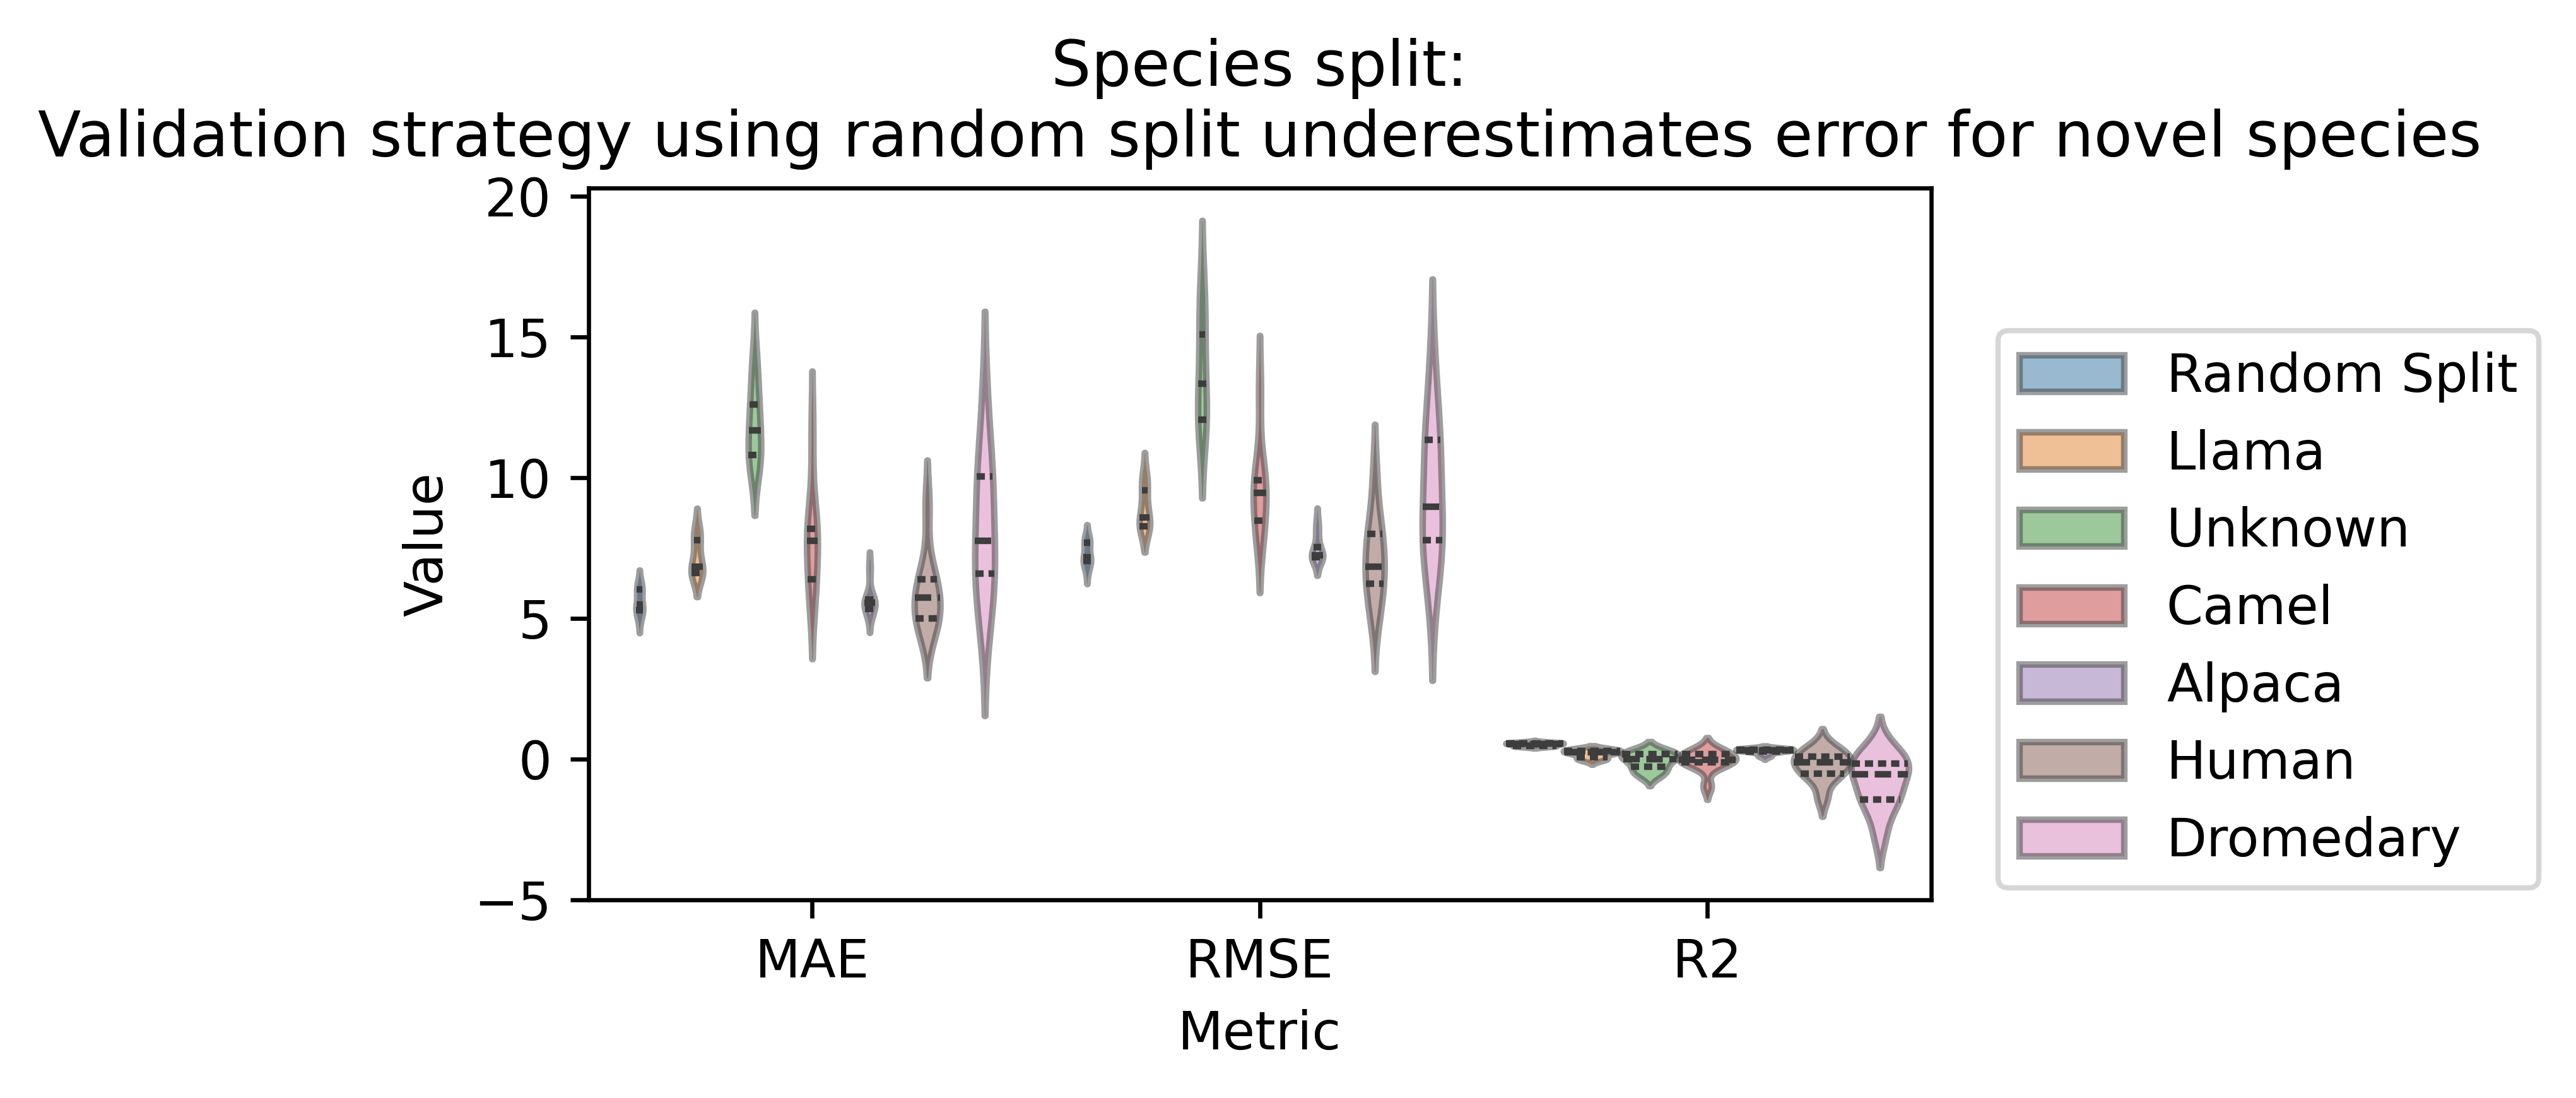

In [64]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', hue = 'Species', data=df_melted, alpha=0.5,inner='quart' , dodge=True, width = 0.9)
plt.title('Species split:\nValidation strategy using random split underestimates error for novel species')
# sns.stripplot(
#     x='Metric', y='Value', data=df_melted,
#     hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
# )

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = ['Biased split', 'Random split']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(              # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/species_split.png', dpi=300, bbox_inches='tight')

plt.show()

## Comute stats for homology splits
### Compute the error when splitting by 2,3, and 4 homology clusters

In [12]:
for i in range(10):
    list_of_error = []
    for column in [f'split_{i}' for i in range(2,5)]:
        for animal in meta[column].unique():
            print(animal)
            x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column=column, holdout_var = animal)
            callback = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
            model = create_model()
            model_history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), callbacks=callback)
            mae, rmse, coeff_det = compute_accuracies(model, x_val, y_val)
            list_of_error.append([column, animal, mae, rmse, coeff_det])

0


/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_35 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 76.1658 - mae: 76.1658 - val_loss: 77.2422 - val_mae: 77.2422
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 75.7008 - mae: 75.7008 - val_loss: 76.1393 - val_mae: 76.1393
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 74.1472 - mae: 74.1472 - val_loss: 74.2922 - val_mae: 74.2922
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 72.2593 - mae: 72.2593 - val_loss: 71.2692 - val_mae: 71.2692
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 69.3275 - mae: 69.3275 - val_loss: 66.4590 - val_mae: 66.4590
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 64.0708 - mae: 64.0708 - val_loss: 58.9298 - val_mae: 58.9298
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 55.8110 - mae: 55.8110 - val_loss: 47.4016 - val_mae: 47.4016
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 43.2799 - mae: 43.2799 - val_loss: 30.1692 - val_mae: 30.1692
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 62.7593 - mae: 62.7593 - val_loss: 39.9014 - val_mae: 39.9014
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 23.7831 - mae: 23.7831 - val_loss: 12.0794 - val_mae: 12.0794
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.5421 - mae: 11.5421 - val_loss: 7.8805 - val_mae: 7.8805
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3006 - mae: 8.3006 - val_loss: 8.2230 - val_mae: 8.2230
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8679 - mae: 7.8679 - val_loss: 7.7742 - val_mae: 7.7742
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9044 - mae: 7.9044 - val_loss: 7.6101 - val_mae: 7.6101
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4409 - mae: 7.4409 - val_loss: 7.6259 - val_mae: 7.6259
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6249 - mae: 7.6249 - val_loss: 7.4474 - val_mae: 7.4474
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 77.1248 - mae: 77.1248 - val_loss: 74.4681 - val_mae: 74.4681
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 77.0001 - mae: 77.0001 - val_loss: 73.7474 - val_mae: 73.7474
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 76.1154 - mae: 76.1154 - val_loss: 72.5368 - val_mae: 72.5368
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 75.0858 - mae: 75.0858 - val_loss: 70.5481 - val_mae: 70.5481
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 72.5500 - mae: 72.5500 - val_loss: 67.3587 - val_mae: 67.3587
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 69.0095 - mae: 69.0095 - val_loss: 62.4115 - val_mae: 62.4115
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 64.2288 - mae: 64.2288 - val_loss: 54.8976 - val_mae: 54.8976
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 56.0243 - mae: 56.0243 - val_loss: 43.7250 - val_mae: 43.7250
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 63.7454 - mae: 63.7454 - val_loss: 36.7431 - val_mae: 36.7431
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.1715 - mae: 21.1715 - val_loss: 14.4541 - val_mae: 14.4541
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.3095 - mae: 12.3095 - val_loss: 9.8623 - val_mae: 9.8623
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1538 - mae: 10.1538 - val_loss: 8.4465 - val_mae: 8.4465
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9958 - mae: 7.9958 - val_loss: 8.3672 - val_mae: 8.3672
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0360 - mae: 8.0360 - val_loss: 8.3268 - val_mae: 8.3268
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9026 - mae: 7.9026 - val_loss: 8.4080 - val_mae: 8.4080
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.9273 - mae: 7.9273 - val_loss: 8.1487 - val_mae: 8.1487
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 62.9477 - mae: 62.9477 - val_loss: 21.9134 - val_mae: 21.9134
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 17.2567 - mae: 17.2567 - val_loss: 12.7956 - val_mae: 12.7956
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4619 - mae: 10.4619 - val_loss: 8.7429 - val_mae: 8.7429
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0348 - mae: 9.0348 - val_loss: 8.4932 - val_mae: 8.4932
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5977 - mae: 8.5977 - val_loss: 8.3535 - val_mae: 8.3535
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2565 - mae: 8.2565 - val_loss: 8.6089 - val_mae: 8.6089
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0145 - mae: 8.0145 - val_loss: 8.0208 - val_mae: 8.0208
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6029 - mae: 8.6029 - val_loss: 8.1630 - val_mae: 8.1630
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 73.4851 - mae: 73.4851 - val_loss: 70.9781 - val_mae: 70.9781
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 71.9883 - mae: 71.9883 - val_loss: 67.7285 - val_mae: 67.7285
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 67.1616 - mae: 67.1616 - val_loss: 61.1694 - val_mae: 61.1694
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 60.7654 - mae: 60.7654 - val_loss: 48.5780 - val_mae: 48.5780
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 46.4123 - mae: 46.4123 - val_loss: 25.6029 - val_mae: 25.6029
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22.6389 - mae: 22.6389 - val_loss: 14.2351 - val_mae: 14.2351
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 16.2442 - mae: 16.2442 - val_loss: 20.5168 - val_mae: 20.5168
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 16.1918 - mae: 16.1918 - val_loss: 7.8737 - val_mae: 7.8737
Epoch 9/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_65 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 63.5884 - mae: 63.5884 - val_loss: 31.7953 - val_mae: 31.7953
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.3944 - mae: 18.3944 - val_loss: 10.9384 - val_mae: 10.9384
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7004 - mae: 9.7004 - val_loss: 8.9187 - val_mae: 8.9187
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0852 - mae: 8.0852 - val_loss: 8.6472 - val_mae: 8.6472
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1398 - mae: 8.1398 - val_loss: 8.2849 - val_mae: 8.2849
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9572 - mae: 7.9572 - val_loss: 8.2595 - val_mae: 8.2595
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6322 - mae: 7.6322 - val_loss: 7.8412 - val_mae: 7.8412
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7354 - mae: 7.7354 - val_loss: 7.9677 - val_mae: 7.9677
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lo

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 63.5890 - mae: 63.5890 - val_loss: 29.2309 - val_mae: 29.2309
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.8668 - mae: 17.8668 - val_loss: 11.3960 - val_mae: 11.3960
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.0987 - mae: 10.0987 - val_loss: 8.4008 - val_mae: 8.4008
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4952 - mae: 8.4952 - val_loss: 8.2926 - val_mae: 8.2926
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1073 - mae: 8.1073 - val_loss: 8.2366 - val_mae: 8.2366
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9985 - mae: 7.9985 - val_loss: 8.4147 - val_mae: 8.4147
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7951 - mae: 7.7951 - val_loss: 8.4609 - val_mae: 8.4609
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8614 - mae: 7.8614 - val_loss: 7.7168 - val_mae: 7.7168
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 

/home/bionets-og86asub/miniforge3/envs/bayer-hack/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,953 (804.50 KB)

 Trainable params: 205,953 (804.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 65.4741 - mae: 65.4741 - val_loss: 44.4167 - val_mae: 44.4167
Epoch 2/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27.8366 - mae: 27.8366 - val_loss: 10.2202 - val_mae: 10.2202
Epoch 3/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0998 - mae: 11.0998 - val_loss: 8.4037 - val_mae: 8.4037
Epoch 4/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6907 - mae: 8.6907 - val_loss: 8.4188 - val_mae: 8.4188
Epoch 5/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.1235 - mae: 8.1235 - val_loss: 8.2649 - val_mae: 8.2649
Epoch 6/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5568 - mae: 8.5568 - val_loss: 8.1112 - val_mae: 8.1112
Epoch 7/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1945 - mae: 8.1945 - val_loss: 7.9592 - val_mae: 7.9592
Epoch 8/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9961 - mae: 7.9961 - val_loss: 7.8343 - val_mae: 7.8343
Epoch 9/500
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - 

## Append the standard training error from earlier.

In [13]:
list_of_error.append(['all','all', amae, armse, acoeff_det])

In [14]:
results2 = pd.DataFrame(list_of_error)
results2.columns = ['clusters','Species', 'MAE', 'RMSE', 'R2']

In [27]:
df_melted = results2.melt(id_vars=['Species', 'clusters'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [28]:
df_melted

,Species,clusters,Metric,Value,color
0,0,split_2,MAE,10.036083,black
1,1,split_2,MAE,7.482063,black
2,0,split_3,MAE,13.207904,black
3,1,split_3,MAE,6.954557,black
4,2,split_3,MAE,3.177036,black
5,0,split_4,MAE,8.258989,black
6,3,split_4,MAE,5.659963,black
7,1,split_4,MAE,2.398753,black
8,2,split_4,MAE,6.263556,black
9,all,all,MAE,7.042751,red


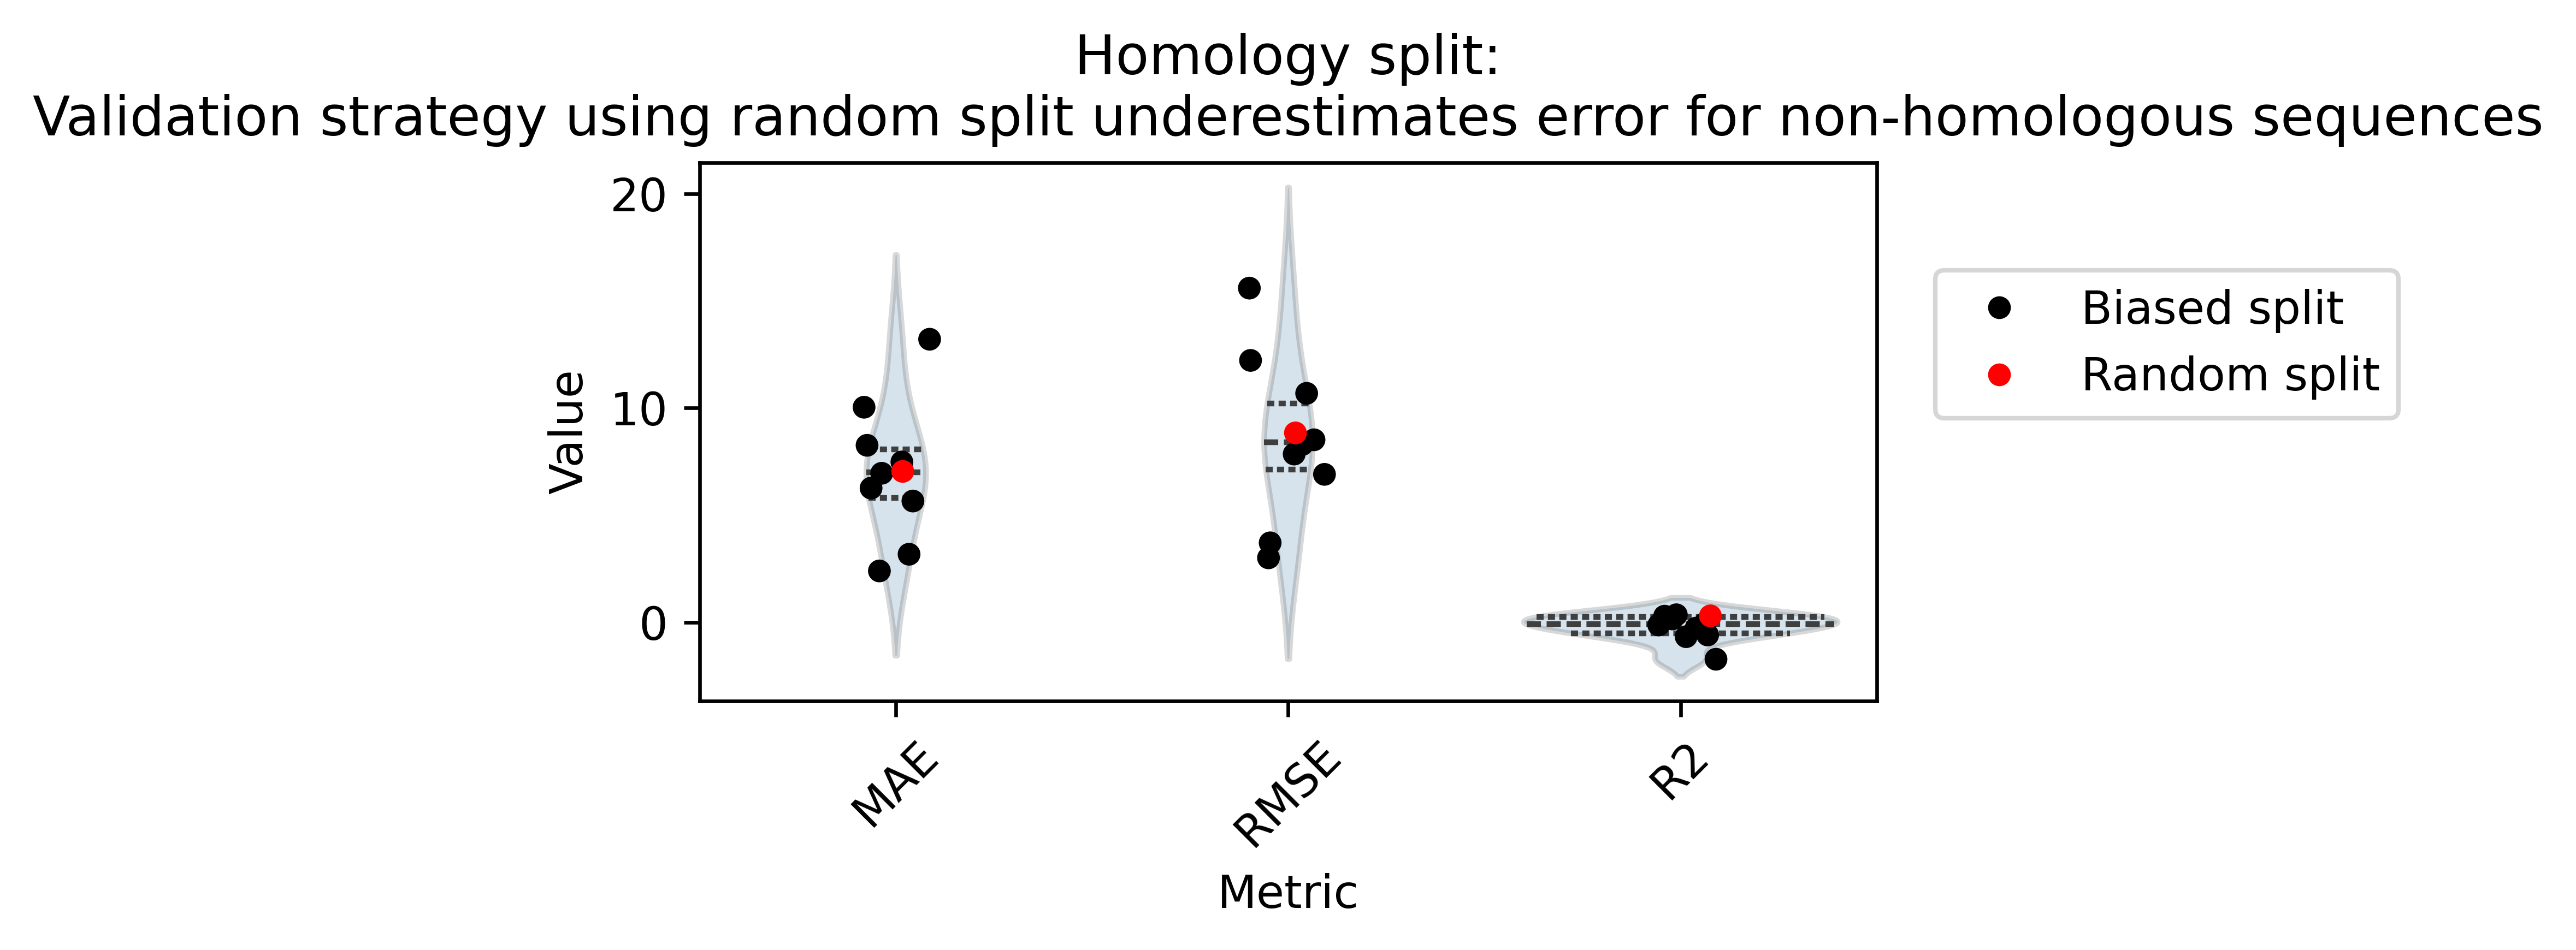

In [29]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' )
plt.title('Homology split:\nValidation strategy using random split underestimates error for non-homologous sequences')
plt.xticks(rotation=45)
sns.stripplot(
    x='Metric', y='Value', data=df_melted,
    hue='color', dodge=False, palette={'red': 'red', 'black': 'black'}, jitter=True, marker='o',
)

handles, labels = plt.gca().get_legend_handles_labels()

# Combine handles and labels manually to update red point labels
species_labels = [ 'Biased split', 'Random split']
color_labels = ['Red Points (Alpaca & Dromedary)', 'Grey Points (Other Species)']

# Use only necessary handles and labels and set them accordingly
plt.legend(
    handles[:len(species_labels)]  , # Keep species and last 2 for colors
    species_labels + color_labels,                 # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/homology_split.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
additional_metadata = pd.read_csv('../data/raw_nbthermo_json_data.csv')

In [19]:
additional_metadata

,id,value,notes,DOI,date,last_update,changes,Tm_nanoDSF,notes_nanoDSF,Tm_DSFsypro,...,cdr3_length,fr4,modification_type,notes_modification,PDB_ID,notes_PDB,model_structure,notes_model,PDB_related,notes_PDB_related
0,1,NRL-N-C2,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,7N0R,NaN
1,2,NRL-N-C2-hop,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,model_AF_0002,NaN,NaN,NaN
2,3,NRL-N-E2,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,7N0I,NaN
3,4,NRL-N-E2-hop,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NRL-N-E10,NaN,https://pubs.acs.org/doi/10.1021/acs.analchem....,NaN,NaN,NaN,NaN,NaN,NaN,...,21.0,WGQGTQVTVSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,544,SP15-96-123StoR,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,545,SP15-96-123KtoI,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,546,SP15-96-123EKtoWI,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,547,SP15-96-123EStoWR,NaN,https://doi.org/10.1371/journal.pone.0160534,NaN,NaN,NaN,NaN,NaN,62.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
from sklearn.ensemble import RandomForestRegressor

### Model Diagnostics - keep it simple and use repeated K-fold cross-validation; predictors are more important.
### We would want to evaluate the model multiple times so we can be confident about using the model.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold
# Fitting Random Forest Regression to the dataset
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [21]:
# define model evaluation method
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# evaluate model
scores = cross_val_score(rf_model, x, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(scores)
print('Mean MAE: %.2f (%.2f)' % (scores.mean(), scores.std()))

Mean MAE: 5.29 (0.30)


In [30]:

species = ['Llama', 'Unknown', 'Camel', 'Alpaca', 'Human', 'Dromedary']
list_of_error = []
for i in range(10):
    for animal in species:
        print(animal)
        x_train, y_train, x_test, y_test, x_val, y_val = split_biased(data, y, split_column='source', holdout_var = animal)
        rf_model.fit(x_train, y_train)
    
        ## Whithin distribution error
        rf_predictions = rf_model.predict(x_test)
        rmse=math.sqrt(mean_squared_error(y_test, rf_predictions))
        mae=mean_absolute_error(y_test, rf_predictions)
        coeff_det=r2_score(y_test, rf_predictions)
    
        list_of_error.append([animal, 'in-distribution', mae, rmse, coeff_det])
        
        ## Out of distribution error
        rf_predictions = rf_model.predict(x_val)
        rmse=math.sqrt(mean_squared_error(y_val, rf_predictions))
        mae=mean_absolute_error(y_val, rf_predictions)
        coeff_det=r2_score(y_val, rf_predictions)
    
    
        list_of_error.append([animal, 'out-of-distribution', mae, rmse, coeff_det])

Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary
Llama
Unknown
Camel
Alpaca
Human
Dromedary


In [31]:
results3 = pd.DataFrame(list_of_error)
results3.columns = ['Species', 'distribution','MAE', 'RMSE', 'R2']
df_melted = results3.melt(id_vars=['Species', 'distribution'], value_vars=['MAE', 'RMSE', 'R2'], var_name='Metric', value_name='Value')
df_melted['color'] = 'black'
df_melted.loc[df_melted.Species == 'all', 'color']= 'red'

In [32]:
df_melted

,Species,distribution,Metric,Value,color
0,Llama,in-distribution,MAE,5.226355,black
1,Llama,out-of-distribution,MAE,6.507178,black
2,Unknown,in-distribution,MAE,5.541048,black
3,Unknown,out-of-distribution,MAE,12.752737,black
4,Camel,in-distribution,MAE,5.474360,black
...,...,...,...,...,...
355,Alpaca,out-of-distribution,R2,0.337591,black
356,Human,in-distribution,R2,0.500356,black
357,Human,out-of-distribution,R2,0.272137,black
358,Dromedary,in-distribution,R2,0.514982,black


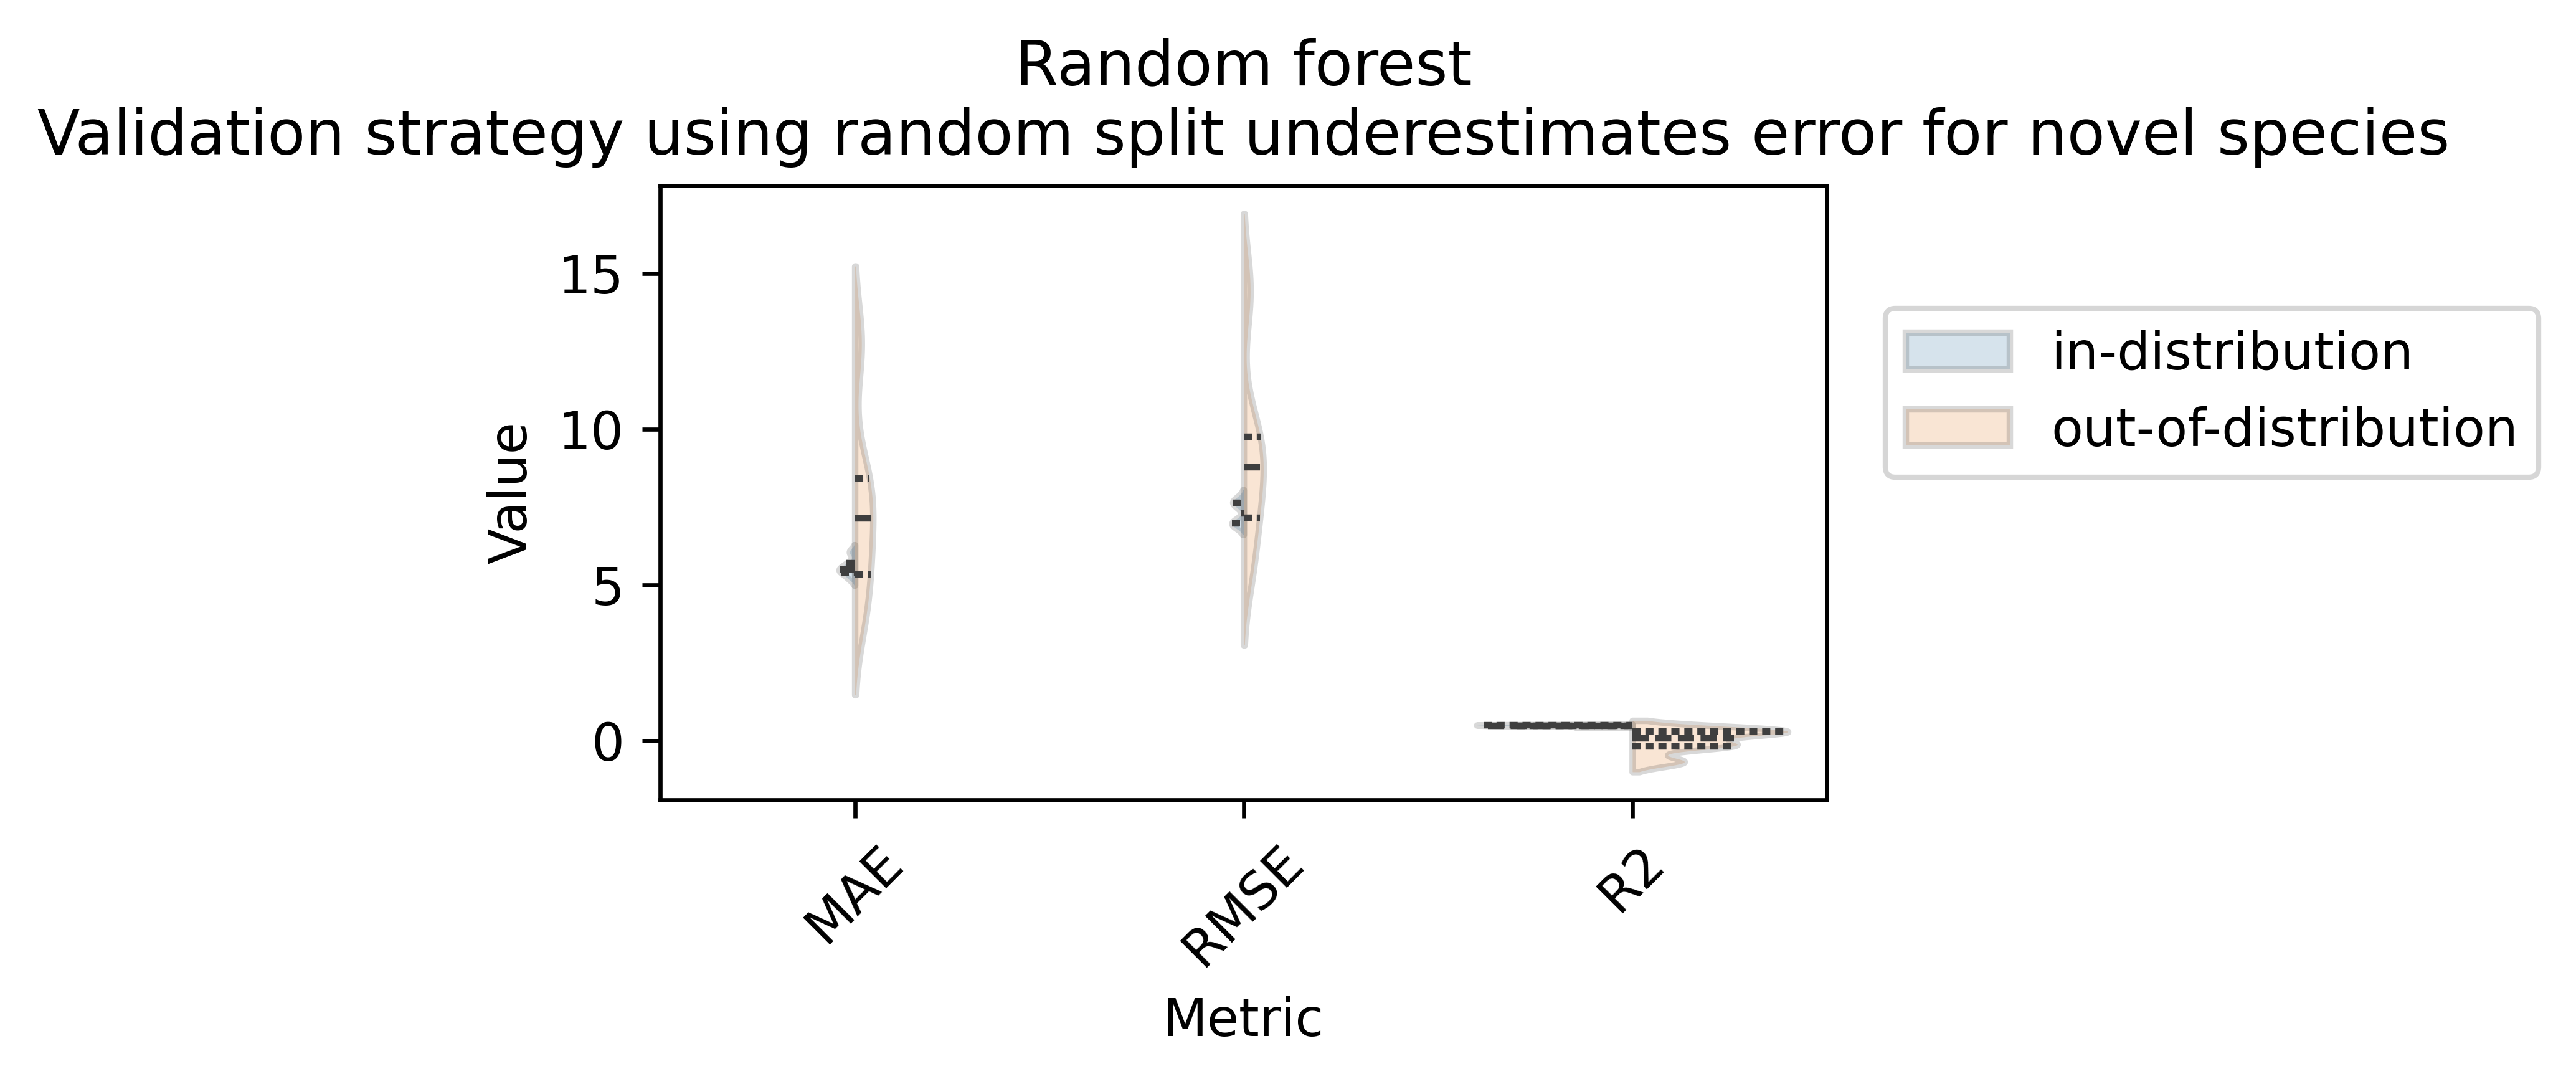

In [33]:
# Creating the boxplot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Metric', y='Value', data=df_melted, alpha=0.2,inner='quart' ,split=True, hue = 'distribution')
plt.title('Random forest\nValidation strategy using random split underestimates error for novel species')
plt.xticks(rotation=45)


handles, labels = plt.gca().get_legend_handles_labels()


# Use only necessary handles and labels and set them accordingly
plt.legend(              # Combine species and color labels
    bbox_to_anchor=(1.05, 0.8), 
    loc='upper left', 
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig('../figures/random_forest.png', dpi=300, bbox_inches='tight')
plt.show()